In [150]:
import os
import keras
from keras.applications import inception_v3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import decode_predictions
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.inception_v3 import decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage.io import imread

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.4


### Using InceptionResNetV2 Model as a object detection model

In [151]:
# create the base pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=True)

225214464/225209952 [==============================] - 12s 0us/step


In [6]:
def transform_img_fn(path_list):
    output = []
    for img_path in path_list:
        img = load_img(img_path, target_size=(299,299))
        x = img_to_array(img)  # this is a Numpy array with shape (3(RGB), width, height)
        x = np.expand_dims(x, axis=0) # this is a Numpy array with shape (1, 3(RGB), width, height)
        x = preprocess_input(x)
        output.append(x)
    return np.vstack(output)


### Loading images

Number of Images found :  8


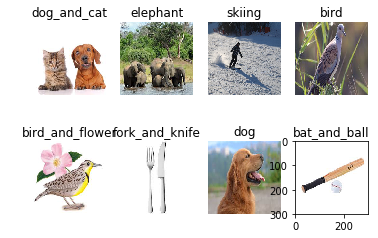

In [175]:
import glob

file_list = glob.glob("./Images/*/*", recursive=True)
print('Number of Images found : ', len(file_list))
#print(file_list)

img_list = transform_img_fn(file_list)

fig = plt.figure()

for idx, img in enumerate(img_list):
    plt.axis('off')
    ax = plt.subplot(2,4,idx+1)
    ax.set_title(file_list[idx].split('/')[2])
    plt.imshow(img_list[idx] / 2 + 0.5)


### Do classification what the object is!

In [154]:
#preds = base_model.predict(np.expand_dims(img_list[0], axis=0))
preds = base_model.predict(img_list, verbose=1)

#print(decode_predictions(preds))

for idx, x in enumerate(decode_predictions(preds)):
    print(file_list[idx])
    for j in x:
        print('   %s\t%5.3f' %(j[1], j[2]))

8/8 [==============================] - 0s 7ms/step
./Images/dog_and_cat/dogandcat2.jpeg
   redbone	0.625
   Rhodesian_ridgeback	0.073
   vizsla	0.018
   bloodhound	0.009
   tabby	0.006
./Images/elephant/elephant.jpeg
   African_elephant	0.751
   tusker	0.114
   Indian_elephant	0.072
   hippopotamus	0.001
   water_buffalo	0.000
./Images/skiing/Minhoe_Skiing.jpg
   ski	0.912
   alp	0.011
   ski_mask	0.005
   shovel	0.001
   snowmobile	0.001
./Images/bird/bird.jpeg
   albatross	0.441
   kite	0.295
   prairie_chicken	0.022
   black_grouse	0.021
   partridge	0.013
./Images/bird_and_flower/birdandflower2.jpeg
   brambling	0.906
   partridge	0.019
   water_ouzel	0.005
   robin	0.004
   prairie_chicken	0.004
./Images/fork_and_knife/forkandknife2.jpeg
   spatula	0.581
   can_opener	0.095
   ladle	0.026
   cleaver	0.020
   carpenter's_kit	0.017
./Images/dog/dog.jpeg
   golden_retriever	0.903
   Irish_setter	0.021
   Labrador_retriever	0.004
   flat-coated_retriever	0.004
   Sussex_spaniel	0.003


### Do Explanation

In [64]:
import os, sys
try:
    import lime
except:
    !pip install --upgrade pip
    !pip install lime

import lime
from lime import lime_image


In [65]:
explainer = lime_image.LimeImageExplainer()

In [155]:
%%time

explanation = explainer.explain_instance(
    img_list[0], 
    base_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=40000)

CPU times: user 7min 19s, sys: 41.8 s, total: 8min 1s
Wall time: 7min 37s


### Check the result

[168, 159, 211, 163, 281]


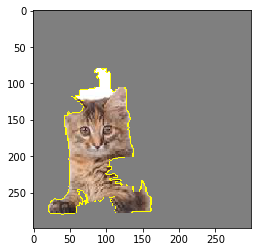

In [160]:
from skimage.segmentation import mark_boundaries

print(explanation.top_labels)

# temp, mask = explanation.get_image_and_mask(
#     explanation.top_labels[0], 
#     positive_only=True, 
#     num_features=10, 
#     hide_rest=True)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[4], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

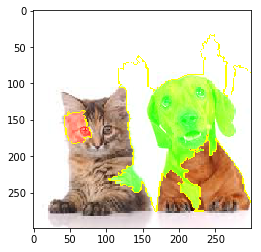

In [170]:
# See 'Pros and Cons(pros in green, cons in red)'

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=15, 
    hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [131]:
data_gen = ImageDataGenerator(rescale=1./255)
input_data_gen = data_gen.flow_from_directory('/home/ubuntu/git-repos/xAI/xAI_LIME/Images',
                                            target_size = (299, 299),
                                              batch_size=1,
                                             shuffle=False)

filenames = input_data_gen.filenames
nb_samples = len(filenames)
print(filenames, nb_samples)
print(input_data_gen.class_indices)

Found 4 images belonging to 5 classes.
['bird/bird.jpeg', 'cat/cat.jpeg', 'dog/dog.jpeg', 'elephant/elephant.jpeg'] 4
{'.ipynb_checkpoints': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'elephant': 4}


In [136]:
preds = base_model.predict_generator(input_data_gen, steps=nb_samples)

for idx, x in enumerate(decode_predictions(preds, top=1)):
    print(x, filenames[idx])

[('n02027492', 'red-backed_sandpiper', 0.081805505)] bird/bird.jpeg
[('n02123045', 'tabby', 0.5448355)] cat/cat.jpeg
[('n02099601', 'golden_retriever', 0.8402856)] dog/dog.jpeg
[('n02504013', 'Indian_elephant', 0.6565038)] elephant/elephant.jpeg


### LIME explanation


In [137]:
from lime import lime_image
import time

In [138]:
explainer = lime_image.LimeImageExplainer()

In [143]:
def predict_fn(output):
    return output[0][2]

for idx, x in enumerate(decode_predictions(preds, top=1)):
    print(x, predict_fn(x), filenames[idx])

[('n02027492', 'red-backed_sandpiper', 0.081805505)] 0.081805505 bird/bird.jpeg
[('n02123045', 'tabby', 0.5448355)] 0.5448355 cat/cat.jpeg
[('n02099601', 'golden_retriever', 0.8402856)] 0.8402856 dog/dog.jpeg
[('n02504013', 'Indian_elephant', 0.6565038)] 0.6565038 elephant/elephant.jpeg


RuntimeError: sequence argument must have length equal to input rank

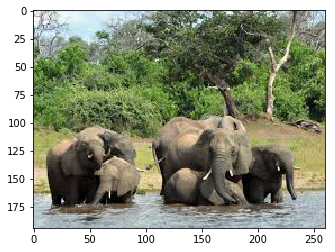

In [157]:
import time

tgt_img = load_img('./Images/elephant/elephant.jpeg')
plt.imshow(tgt_img)
x = img_to_array(tgt_img)  # this is a Numpy array with shape (3(RGB), width, height)
x = np.expand_dims(x, axis=0) # this is a Numpy array with shape (1, 3(RGB), width, height)
pred = base_model.predict(x)

tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(x*1./255, base_model.predict, top_labels=5, hide_color=0, num_samples=1000)

print(time.time() - tmp)